In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import pickle
import obspy
from scipy.signal import find_peaks
import os
import pandas as pd

import cmcrameri.cm as cmc

from matplotlib import patches
import seaborn as sns


In [3]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [13]:
scardec_name = os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec')[0]

In [14]:
db = combined[combined['scardec_name']==scardec_name]

In [15]:
db

,scardec_name,isc_name,year,month,day,hour,minute,second,latitude,longitude,depth,scardec_magnitude,scardec_mag_type,moment,isc_magnitude,isc_mag_type,isc_mag_unc,days_count
3342,FCTs_20170818_025925_NORTH_OF_ASCENSION_ISLAND,NaN,2017,8,18,2,59,25.0,-1.112,-13.66,17.0,6.591,mw,9.698000e+18,NaN,NaN,NaN,9361


In [24]:
def moment_in_different_windows(window = None, window_prop = None):
    if window is None and window_prop is None:
        window_prop = 1

    diff = []
    moments = []

    romb = []
    simpson = []
    trapz = []

    simpson_short = []

    durations = []

    magnitudes = []

    for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
        db = combined[combined['scardec_name']==scardec_name]

        magnitudes.append(db['scardec_magnitude'].values[0])
        time_opt = []
        momentrate_opt = []

        time_moy = []
        momentrate_moy = []

        event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
        starts = [n for n, l in enumerate(event) if l.startswith('fctmoy')]
        with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
            lines = f.read().splitlines()

        lines = lines[2:]
        for line in lines:
            split = line.split(' ')
            split = [s for s in split if s not in ['', ' ', '\n']]
            time_opt.append(float(split[0]))
            momentrate_opt.append(float(split[1]))

        momentrate_opt = np.array(momentrate_opt)

        not_zero = np.where(momentrate_opt > 0)[0]

        start = min(not_zero)
        end = max(not_zero)
        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        simpson.append(scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0]))
        trapz.append(scipy.integrate.trapezoid(momentrate_opt, dx = time_opt[1]-time_opt[0]))
        moments.append(db['moment'].values[0])

        if window_prop is None: #using static time window
            end_window = int((end-start)*(window/duration))
        else: #based on proportion of duration
            end_window = int((end-start)*window_prop)

        simpson_short.append(scipy.integrate.simpson(momentrate_opt[start:start + end_window], dx = time_opt[1]-time_opt[0]))
    return moments, simpson, simpson_short, trapz, durations, magnitudes

In [25]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [26]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    if start == end:
        end += 1
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [27]:
def plot_scatter_figures(proportion, root_times, moments, durations):
    root_times = np.array(root_times)
    moments = np.array(moments)
    durations = np.array(durations)

    plt.scatter(root_times, durations, c = np.log10(moments), cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('Duration (s)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'log10(moment)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_duration.png')
    plt.close()

    plt.scatter(root_times, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'time to release {proportion*100}% of moment (s)')
    plt.colorbar(label = 'Duration (s)')
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

    plt.scatter(root_times/durations, np.log10(moments), c = durations, cmap = cmc.batlow, alpha = 0.5)
    plt.ylabel('log10(moment)')
    plt.xlabel(f'proportion of duration to release {proportion*100}% of moment')
    plt.colorbar()
    plt.xlim(0, 1)
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_moment_proportion/fraction_of_duration_for_{proportion*100}_percent_moment_against_moment.png')
    plt.close()

In [28]:
def plot_hist_figures(proportion, root_times, durations):
    root_times = np.array(root_times)
    durations = np.array(durations)

    plt.hist(root_times/durations, bins = 100)

    plt.ylabel('Frequency')
    plt.xlabel(f'proportion of duration to release {proportion*100}% of moment')
    plt.xlim(0, 1)
    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_moment_proportion/histogram_fraction_of_duration_for_{proportion*100}_percent_moment.png')
    plt.close()

In [29]:
def plot_hist_figures_all(proportions_list, all_root_times, all_durations):
    fig, ax = plt.subplots()
    for root_times, durations, proportion in zip(all_root_times, all_durations, proportions_list):
        root_times = np.array(root_times)
        durations = np.array(durations)

        color = next(ax._get_lines.prop_cycler)["color"]

        ax.hist(root_times/durations, bins = 100, alpha = 0.1, histtype='stepfilled', density=True, color = color)
        ax.hist(root_times/durations, bins = 100, histtype='step', density=True, color = color)
        ax.plot([],[], label = proportion, color = color)

        ax.set_ylabel('Frequency')
        ax.set_xlabel(f'proportion of duration to release proportion of moment')

        ax.set_xlim(0, 1)
    ax.legend()

    plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/moment_intervals/time_for_moment_proportion/combined_histogram_fraction_of_duration_for_percent_moment.png')
    plt.close()

In [87]:
moments, simpson, simpson_short, trapz, durations, magnitude = moment_in_different_windows(window = 2)

In [88]:
simpson = np.array(simpson)
simpson_short = np.array(simpson_short)
trapz = np.array(trapz)
durations = np.array(durations)
moments = np.array(moments)
magnitude = np.array(magnitude)


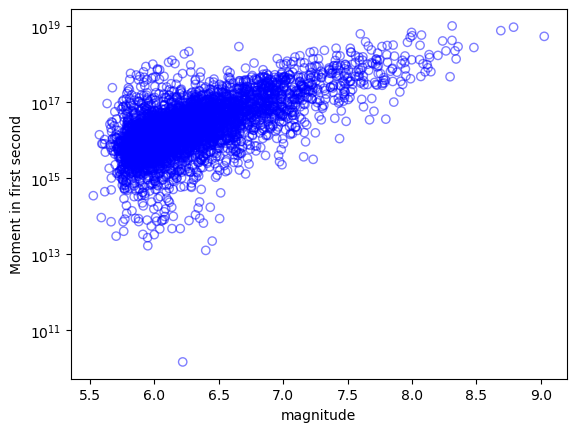

In [73]:
plt.scatter(magnitude,
            simpson_short,
            label='moy',
            alpha = 0.5,
            facecolors='none',
            edgecolors='blue')
plt.ylabel(f'Moment in first second')
plt.xlabel('magnitude')
plt.yscale('log')
#plt.legend()
plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/abs_moment_in_first_second_vs_magnitude.png')#, transparent=True)
plt.show()

In [74]:
b

3.026052083928674

In [75]:
m

0.7158219175217901

Spearman correlation: 0.6301795834012792, p-value: 0.0


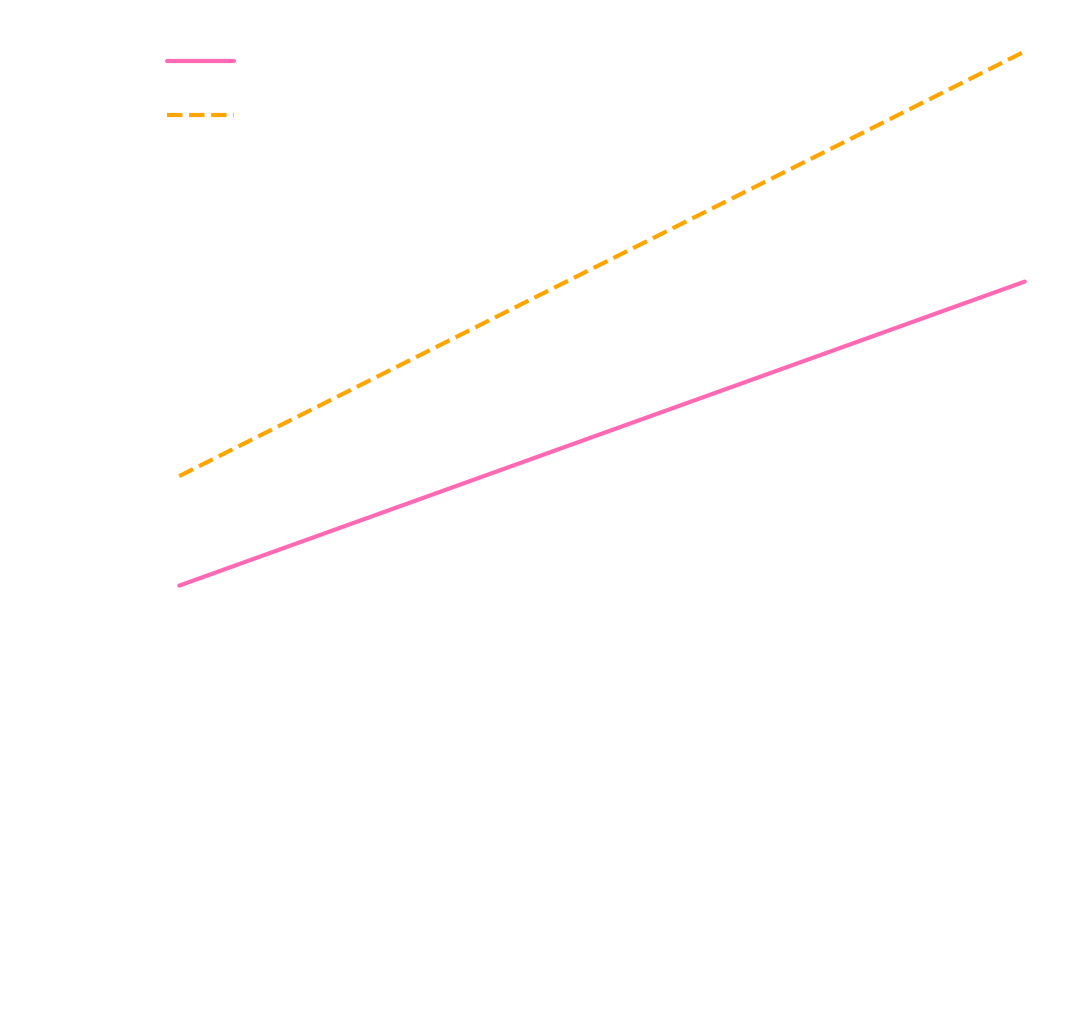

In [85]:
sns.set_theme(style='ticks',
              context='poster',
              rc={'figure.figsize':(12,12),
                  'font.size':36})
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)
plt.scatter(simpson,
            simpson_short,
            alpha = 0.5,
            facecolors='none',
            edgecolors='white')
plt.ylabel(f'Moment in first second')
plt.xlabel('Moment')
plt.yscale('log')
plt.xscale('log')

spearman_r, spearman_p = stats.spearmanr(simpson, simpson_short)
print(f'Spearman correlation: {spearman_r}, p-value: {spearman_p}')

m, b = np.polyfit(np.log10(simpson), np.log10(simpson_short), 1)
#m, b = np.polyfit(simpson, simpson_short, 1)

plt.plot(np.array([10e16, 10e19, 10e23]),
        10**(m * np.log10(np.array([10e16, 10e19, 10e23])) + b),
        c='hotpink',
        label = fr'Best fit: $\log_{{10}}(M_0^{{1 s}})$ = {m:.2f}$\log_{{10}}(M_0)$ + {b:.2f}',
        linestyle = '-')

plt.plot(np.array([10e16, 10e19, 10e23]), np.array([10e16, 10e19, 10e23]), c='orange', linestyle='--', label='1:1 line')

plt.legend(facecolor = '#002147', edgecolor = 'white', labelcolor = 'white', fontsize = 24, framealpha=0)
plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/abs_moment_in_first_second_vs_moment.png', transparent=True)
plt.show()

Spearman correlation: 0.5303748094755283, p-value: 1.696807681433622e-295


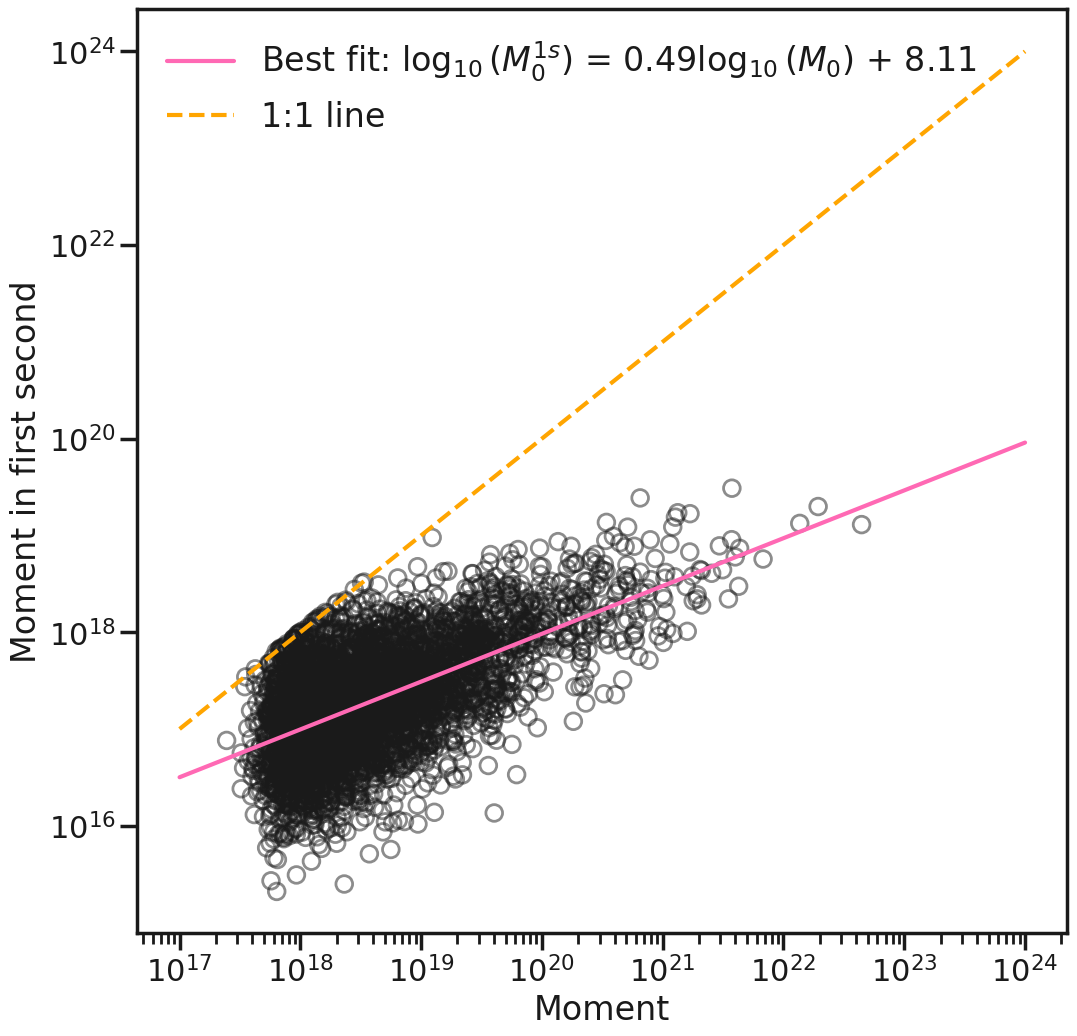

In [91]:
sns.set_theme(style='ticks',
              context='poster',
              rc={'figure.figsize':(12,12),
                  'font.size':36})
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}
plt.rcParams.update(params)
plt.scatter(simpson,
            simpson_short,
            alpha = 0.5,
            facecolors='none',
            edgecolors='k')
plt.ylabel(f'Moment in first second')
plt.xlabel('Moment')
plt.yscale('log')
plt.xscale('log')

spearman_r, spearman_p = stats.spearmanr(simpson, simpson_short)
print(f'Spearman correlation: {spearman_r}, p-value: {spearman_p}')

m, b = np.polyfit(np.log10(simpson), np.log10(simpson_short), 1)
#m, b = np.polyfit(simpson, simpson_short, 1)

plt.plot(np.array([10e16, 10e19, 10e23]),
        10**(m * np.log10(np.array([10e16, 10e19, 10e23])) + b),
        c='hotpink',
        label = fr'Best fit: $\log_{{10}}(M_0^{{1 s}})$ = {m:.2f}$\log_{{10}}(M_0)$ + {b:.2f}',
        linestyle = '-')

plt.plot(np.array([10e16, 10e19, 10e23]), np.array([10e16, 10e19, 10e23]), c='orange', linestyle='--', label='1:1 line')

plt.legend(facecolor = '#002147', edgecolor = 'white', labelcolor = 'k', fontsize = 24, framealpha=0)
plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/abs_moment_in_first_two_seconds_vs_moment.png', transparent=True)
plt.show()

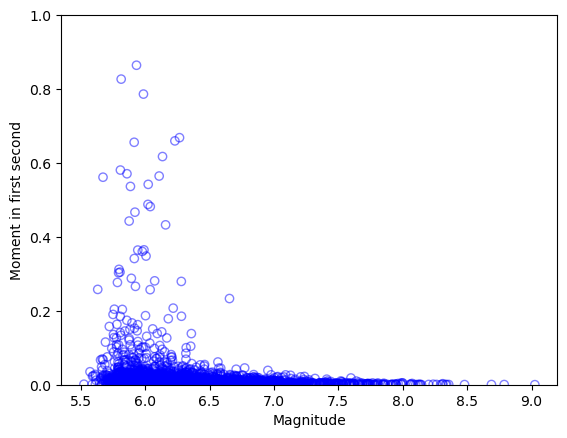

In [78]:
plt.scatter(magnitude,
            simpson_short/simpson,
            label='moy',
            alpha = 0.5,
            facecolors='none',
            edgecolors='blue')
plt.ylabel(f'Moment in first second')
plt.xlabel('Magnitude')
plt.ylim(0, 1)
#plt.legend()
plt.savefig(f'/home/earthquakes1/homes/Rebecca/phd/stf/figures/poster/relative_moment_in_first_second')#, transparent=True)
plt.show()